Source declaration:
- The idea for the experiment as conducted in the code to follow is inspired by discussions among the members of the space weather research group at the university of Bern.
- The construction of the affine coupling layer flow is inspired and taken in part from Brennan Gebotys, https://gebob19.github.io/normalizing-flows/, last accessed on January 18, 2024.

This code experiments with normalizing flows used to invert Milne-Eddington atmospheres. In this case, a map of a certain FOV of the sun is taken and inverted using the Milne-Eddington algorithm. Train and test splits are subsequently made, where a normalizing flow (self-made affine coupling layer normalizing flow) is trained on the train split and tested on the test split. It provides an inital test for the idea, that inversions can be vastly accelerated by means of using normalizing flows. That is, a map is initially inverted using a (sophisticated) inversion algorithm. After that, a normalizing flow can be trained on this inverted map and then applied to similar FOV's and maps, thereby greatly accelerating the inversion and furthermore providing one with not only parameter values, but distributions!

# Import packages and data

In [1]:
# Import all important packages and set parameters
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#!pip install emcee
#!pip install corner
#!pip install nflows
import emcee
from __future__ import division
from tqdm import tqdm
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy.interpolate import CubicSpline
import torch
import torch.nn as nn
import itertools
import numpy as np
import pandas as pd
from math import pi 
import seaborn as sns
import corner
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn import functional as F

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.coupling import PiecewiseQuadraticCouplingTransform
from nflows.transforms.permutations import ReversePermutation
from nflows import distributions, flows, transforms, utils
from nflows.nn import nets

from sklearn.model_selection import train_test_split

from utils import *

In [2]:
# Fixing seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)

In [3]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.1.0+cu121


# Import map

In [4]:
# Import all necessary packages for data generation
import os

# Save current directory
current_directory = os.getcwd()

# Change working path to pyMilne directory and load Milne-Eddington code
os.chdir('/home/dz/pyMilne') # Reference to pyMilne directory
import MilneEddington

In [5]:
# Decide to work in float32
dtype = 'float32'

In [6]:
# Read in a fits file of image data of the sun (Values for the four Stokes parameters at different wavelengths per pixel)
filename = '/home/dz/maps/Prepared_map_SIR_AR13014_nb_6302_2022-05-17T10_07_10_frame_0.fits' # Change to storage path of data
map_inv, hdulist, regions = read_map(filename)

In [7]:
# Define labels and units for data
stokes_labels = ['$I$ (normalized intensity)', '$Q/I$', '$U/I$', '$V/I$']
labels = ['$|\\bm{B}|$', '$\\theta$', '$\\varphi$', '$v_{los}$', '$\\Delta \\lambda_D = v_{dop}\\lambda/c$', '$\\eta_0$', '$a$', '$S_0$', '$S_1$']
units = ['$[\\mathrm{G}]$', '$[\\si{\\radian}]$', '$[\\si{\\radian}]$', '$[\\si{\kilo\meter\second^{-1}}]$', '$[\\si{\\angstrom}]$', '', '', '', '']
l_units = [label + ' ' + unit for label, unit in zip(labels, units)]

In [8]:
# Restore working directory
os.chdir(current_directory)

# Invert map using the Milne-Eddington algorithm

In [9]:
# Do actual inversion
inverted_map, errors_map, syn_out = invert_milne(map_inv, regions)

line::line: Initialized [6302.493100] ->   3 Zeeman components
InvertMany: Processed -> 100%
/home/dz/pyMilne/MilneEddington.py:354: RuntimeWarning: divide by zero encountered in scalar divide
  error[yy,xx,kk] /= Hdiag[kk]


pyMilne::dealloc: cleaning-up...


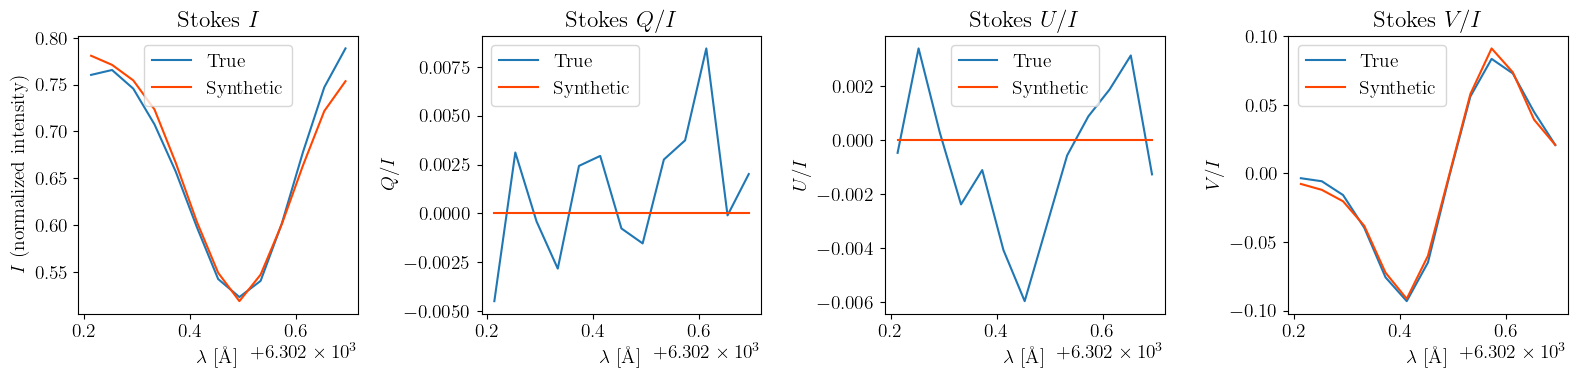

In [10]:
# Plot results for the first pixel
plot_stokes(map_inv, syn_out, np.array(regions[0][0]), int(0), int(0), stokes_labels)

In [11]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.1.0+cu121


# Create neccessary datasets

In [12]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [13]:
# Instantiate params dictionary
settings = dictionary()

In [14]:
# Create dataset of true data
spectra = map_inv.reshape(map_inv.shape[0]*map_inv.shape[1], map_inv.shape[2]*map_inv.shape[3])
parameters = inverted_map.reshape(inverted_map.shape[0]*inverted_map.shape[1], inverted_map.shape[2])

In [15]:
# Print shape of data
print(f'Shape of true spectra data is: {spectra.shape}')
print(f'Shape of true parameters data is: {parameters.shape}')

Shape of true spectra data is: (378000, 52)
Shape of true parameters data is: (378000, 9)


In [16]:
# Test for NaN values in data
has_nan = np.isnan(spectra).any()
if has_nan==False:
    has_nan = np.isnan(parameters).any()

if has_nan:
    print('The data contain NaN values.')
else:
    print('The data do not contain any NaN values.')

The data do not contain any NaN values.


In [17]:
# Define input x and context y
x = parameters # parameters 
y = spectra # spectra

# Make training and testing splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (264600, 9)
Context y_std_train shape: (264600, 52)
Output z_train shape: (264600, 9)
Input x_std_test shape: (113400, 9)
Context y_std_test shape: (113400, 52)
Output z_test shape: (113400, 9)


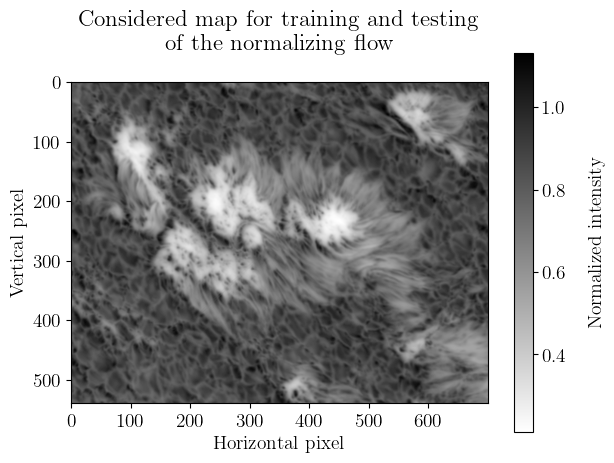

In [18]:
# Show the considered map used for training and testing
plt.title('Considered map for training and testing\nof the normalizing flow\n')
plt.imshow(map_inv[:,:,0,0], cmap='binary')
plt.xlabel('Horizontal pixel')
plt.ylabel('Vertical pixel')
plt.colorbar().set_label('Normalized intensity', rotation=90, labelpad=15)

# Show the plot
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-1-considered-map.pdf')
plt.show()

# Define coupling layer and normalizing flow

In [19]:
# Define coupling layer (affine coupling type)
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, context_size=None):
        """
        Initializes the coupling layer.

        input_size: Size (dimension) of the input, which is to be transformed to a base distribution (standard normal distribution).
        hidden_size: Size (dimension) of the hidden layers of the neural networks involved in the transformations.
        """
        # Initialize object
        super().__init__()

        # Assign variables to coupling layer input
        self.D, self.d, self.m, self.h = context_size, input_size, int(input_size/2), hidden_size

        # Decide on size of neural network input
        if context_size is not None:
            self.net_in = self.m + self.D
        else:
            self.net_in = self.m

        # Define neural network implementing the shift parameter mu of an affine function: f(x) = sig*x + mu
        self.sig_net = nn.Sequential(
                    nn.Linear(self.net_in, self.h),
                    nn.LeakyReLU(),
                    nn.Linear(self.h, (self.d-self.m)))

        # Define neural network implementing the scale parameter sigma of an affine function: f(x) = sig*x + mu
        self.mu_net = nn.Sequential(
                    nn.Linear(self.net_in, self.h),
                    nn.LeakyReLU(),
                    nn.Linear(self.h, (self.d-self.m)))

    def forward(self, x, context=None, flip=False, inverse=False):
        """
        Defines the forward and inverse direction of the coupling layer.

        x: Input, which is to be transformed to a base distribution (standard normal distribution).
        context: Context, on which the input data is conditioned.
        flip: Default is False; if True, input is split into two and flipped after every coupling layer.
        inverse: Default is False; if True, the inverse direction of the normalizing flow is active.
        """
        # Split input into two parts
        x1, x2 = torch.split(x, [self.m, self.d - self.m], dim=1)

        # Flip the two parts, if flip is True
        if flip:
            x1, x2 = torch.split(x, [self.d - self.m, self.m], dim=1)
            x2, x1 = x1, x2

        # If there is context, concatenate it with one part of the input to feed to the neural networks
        if context is not None:
            xy = torch.cat([x1, context], dim=-1)
        else:
            xy = x1

        # Instantiate and calculate neural networks for the scale and shift parameters sig and mu
        mu = self.mu_net(xy)
        sig = self.sig_net(xy)

        # Calculate forward transformation, if inverse=False
        if not inverse:
            z1, z2 = x1, mu + x2 * torch.exp(sig)

        # Calculate inverse transformation, if inverse=True
        else:
            z1, z2 = x1, (x2 - mu) * torch.exp(-sig)

        # Again flip the data, if flip is True
        if flip:
            z2, z1 = z1, z2 

        # Concatenate unprocessed and processed input to an output tensor
        z = torch.cat([z1, z2], dim=-1)

        # Calculate log-likelihood
        pz = MultivariateNormal(torch.zeros(x.shape[1]), torch.eye(x.shape[1]))
        log_pz = pz.log_prob(z)
 
        # Calculate determinant of log-likelihood
        log_det_J = sig.sum(-1)

        # Return output tensor, log-likelihood and determinant of log-likelihood
        return z, log_pz, log_det_J

In [20]:
# Define normalizing flow (RNVP type)
class NormalizingFlow(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, context_size=None):
        """
        Initializes the normalizing flow architecture

        input_size: Size (dimension) of the input, which is to be transformed to a base distribution (standard normal distribution).
        hidden_size: Size (dimension) of the context, on which the input data is conditioned.
        num_layers: Integer defining the total coupling layer number of the normalizing flow.
        context_size: Size (dimension) of the context, on which the input is conditioned.
        """
        # Initialized object
        super().__init__()

        # Create a list of coupling layers with specified characteristics
        self.bijectors = nn.ModuleList([
            CouplingLayer(input_size, hidden_size, context_size) for _ in range(num_layers)
        ])

        # Create a list of alternating flip values for all coupling layers of the transformation
        self.flips = [True if i%2 else False for i in range(num_layers)]
        
    def forward(self, x, context=None, inverse=False):
        """
        Defines the forward and inverse direction of the normalizing flow

        x: Input, which is to be transformed to a base distribution (standard normal distribution).
        context: Context, on which the input data is conditioned.
        flip: Default is False; if True, input is split into two and flipped after every coupling layer.
        inverse: Default is False; if True, the inverse direction of the normalizing flow is active.
        """
        # Define empty list to store log-likelihoods and determinants of log-likelihoods
        lg_pz = []
        lg_det_J = []

        # Calculate resulting log-likelihoods and determinants thereof in forward direction
        if not inverse:
            for biijector, f in zip(self.bijectors, self.flips):
                x, lpz, ldj = biijector(x, context=context, inverse=False, flip=f)
                lg_pz.append(lpz)
                lg_det_J.append(ldj)

        # Calculate resulting log-likelihoods and determinants thereof in inverse direction
        else:
            for biijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
                x, lpz, ldj = biijector(x, context=context, inverse=True, flip=f)
                lg_pz.append(lpz)
                lg_det_J.append(ldj)
                
        # Return processed input, the total log-likelihood and the determinant of the total log-likelihood
        return x, sum(lg_pz), sum(lg_det_J)

# Define loss function and dataloader

## Define loss function

In [21]:
# Define loss function
def loss_function(model, input, context=None):
    """
    Calculates the loss for training a normalizing flow.

    model: Normalizing flow model.
    x: Input, which is to be transformed to a base distribution (standard normal distribution).
    context: Context, on which the input data is conditioned.
    """
    # Calculate processed input (output), total log-likelihood and determinant of total log-likelihood
    z, log_pz, log_det_J = model(input, context=context, inverse=False)

    # Calculate and return loss as given by the change of variable theorem of probability theory
    loss = -torch.mean(log_pz + log_det_J)
    return loss

## Define dataloader

In [22]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [23]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([264600, 9])
Size of y_std_train: torch.Size([264600, 52])
Size of z_train: torch.Size([264600, 9])
Size of x_std_test: torch.Size([113400, 9])
Size of y_std_test: torch.Size([113400, 52])
Size of z_test: torch.Size([113400, 9])


In [24]:
# Define dataloaders for training and testing
settings.batch_size = 256
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

# Instantiate normalizing flow and training settings

In [25]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 16
settings.num_layers = 7

# Instantiate the normalizing flow
normalizing_flow_milne_eddington = NormalizingFlow(settings.input_size, settings.hidden_size, settings.num_layers, context_size=settings.context_size)

In [26]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 10

# Define optimizer and scheduler
optim = torch.optim.Adam(normalizing_flow_milne_eddington.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, settings.scheduling_rate)

# Train and test the flow

## Train the flow

Train normalizing flow on a train dataset of all spectra and corresponding features. Take then a sample from the test split of the spectra and calculate the feature distribution using the trained normalizing flow and see, if the normalizing flow gives the true value for the features in terms of the mean values of the calculated feature distributions.

In [27]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        normalizing_flow_milne_eddington.train()
        optim.zero_grad()
        loss = loss_function(normalizing_flow_milne_eddington, batch_x, context=batch_y)
        loss.backward()
        optim.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        normalizing_flow_milne_eddington.eval()
        loss = loss_function(normalizing_flow_milne_eddington, batch_x, context=batch_y)
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 1/10 train loss: 0.2763
Epoch 1/10 test loss: 0.2447
Epoch 2/10 train loss: 0.2391
Epoch 2/10 test loss: 0.2351
Epoch 3/10 train loss: 0.2333
Epoch 3/10 test loss: 0.2319
Epoch 4/10 train loss: 0.2312
Epoch 4/10 test loss: 0.2307
Epoch 5/10 train loss: 0.2303
Epoch 5/10 test loss: 0.2303
Epoch 6/10 train loss: 0.2300
Epoch 6/10 test loss: 0.2301
Epoch 7/10 train loss: 0.2299
Epoch 7/10 test loss: 0.2300
Epoch 8/10 train loss: 0.2298
Epoch 8/10 test loss: 0.2300
Epoch 9/10 train loss: 0.2298
Epoch 9/10 test loss: 0.2300
Epoch 10/10 train loss: 0.2298
Epoch 10/10 test loss: 0.2300


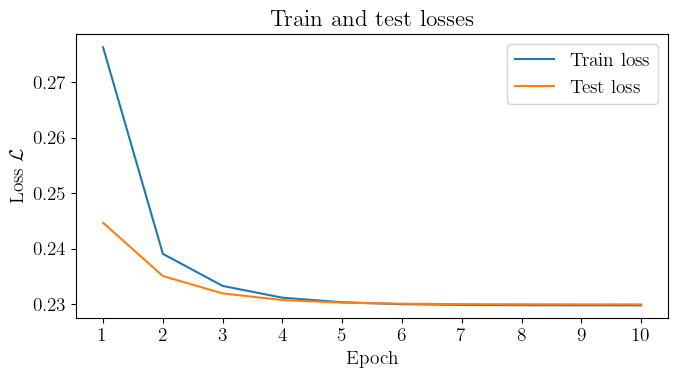

In [28]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/10)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-1-loss.pdf')

## Test the flow

In [29]:
# Take an experiment sample
settings.which_dataindex = 13246
settings.exp_samples = 5000
expval = x_test[settings.which_dataindex,:]
expobs = y_test[settings.which_dataindex,:]
z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], z_exp.shape[0], axis=0))
y_exp_std = torch.tensor(y_scaler_test.transform(y_exp), dtype=torch.float32)

# Propagate it through the inverse normalizing flow
rec_x_std, _, _ = normalizing_flow_milne_eddington(z_exp, context=y_exp_std, inverse=True)
rec_x_std = rec_x_std.detach().numpy()
rec_x = x_scaler_test.inverse_transform(rec_x_std)

In [30]:
# Plot actual values of features for tested spectrum
for i in range(len(labels)):
    print(f'{labels[i]}: {x_test[settings.which_dataindex,i]}')

$|\bm{B}|$: 185.9123992919922
$\theta$: 2.199112892150879
$\varphi$: 2.9896440505981445
$v_{los}$: -0.755156397819519
$\Delta \lambda_D = v_{dop}\lambda/c$: 0.023152273148298264
$\eta_0$: 31.518218994140625
$a$: 0.6928480267524719
$S_0$: 0.43345844745635986
$S_1$: 0.39149683713912964


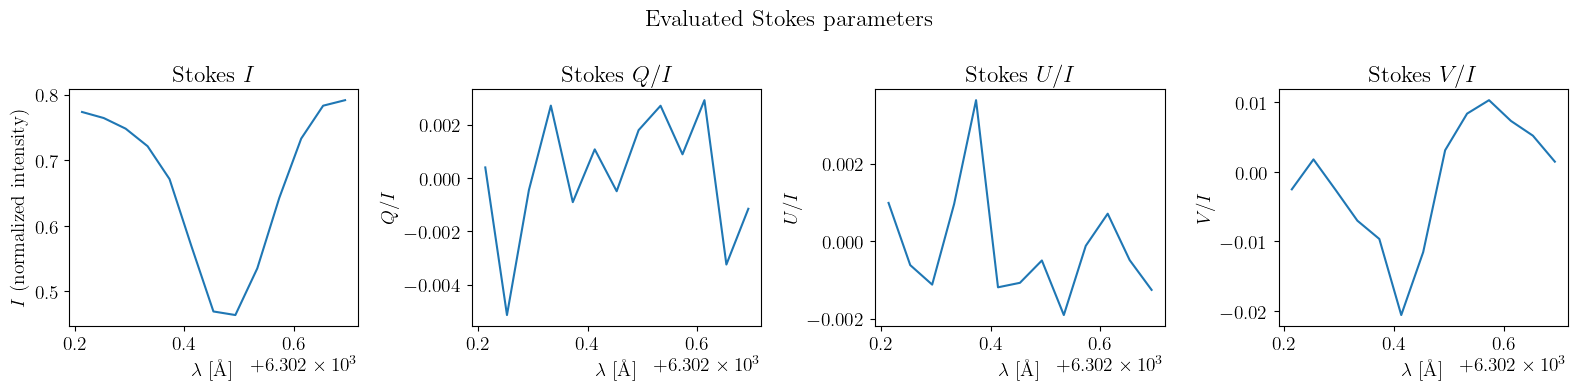

In [31]:
plot_stokes_simple(y_test, regions[0][0], settings.which_dataindex, stokes_labels, title='Evaluated Stokes parameters', savename='nf-milne-eddington-example-1-corner-spectrum-nf.pdf')

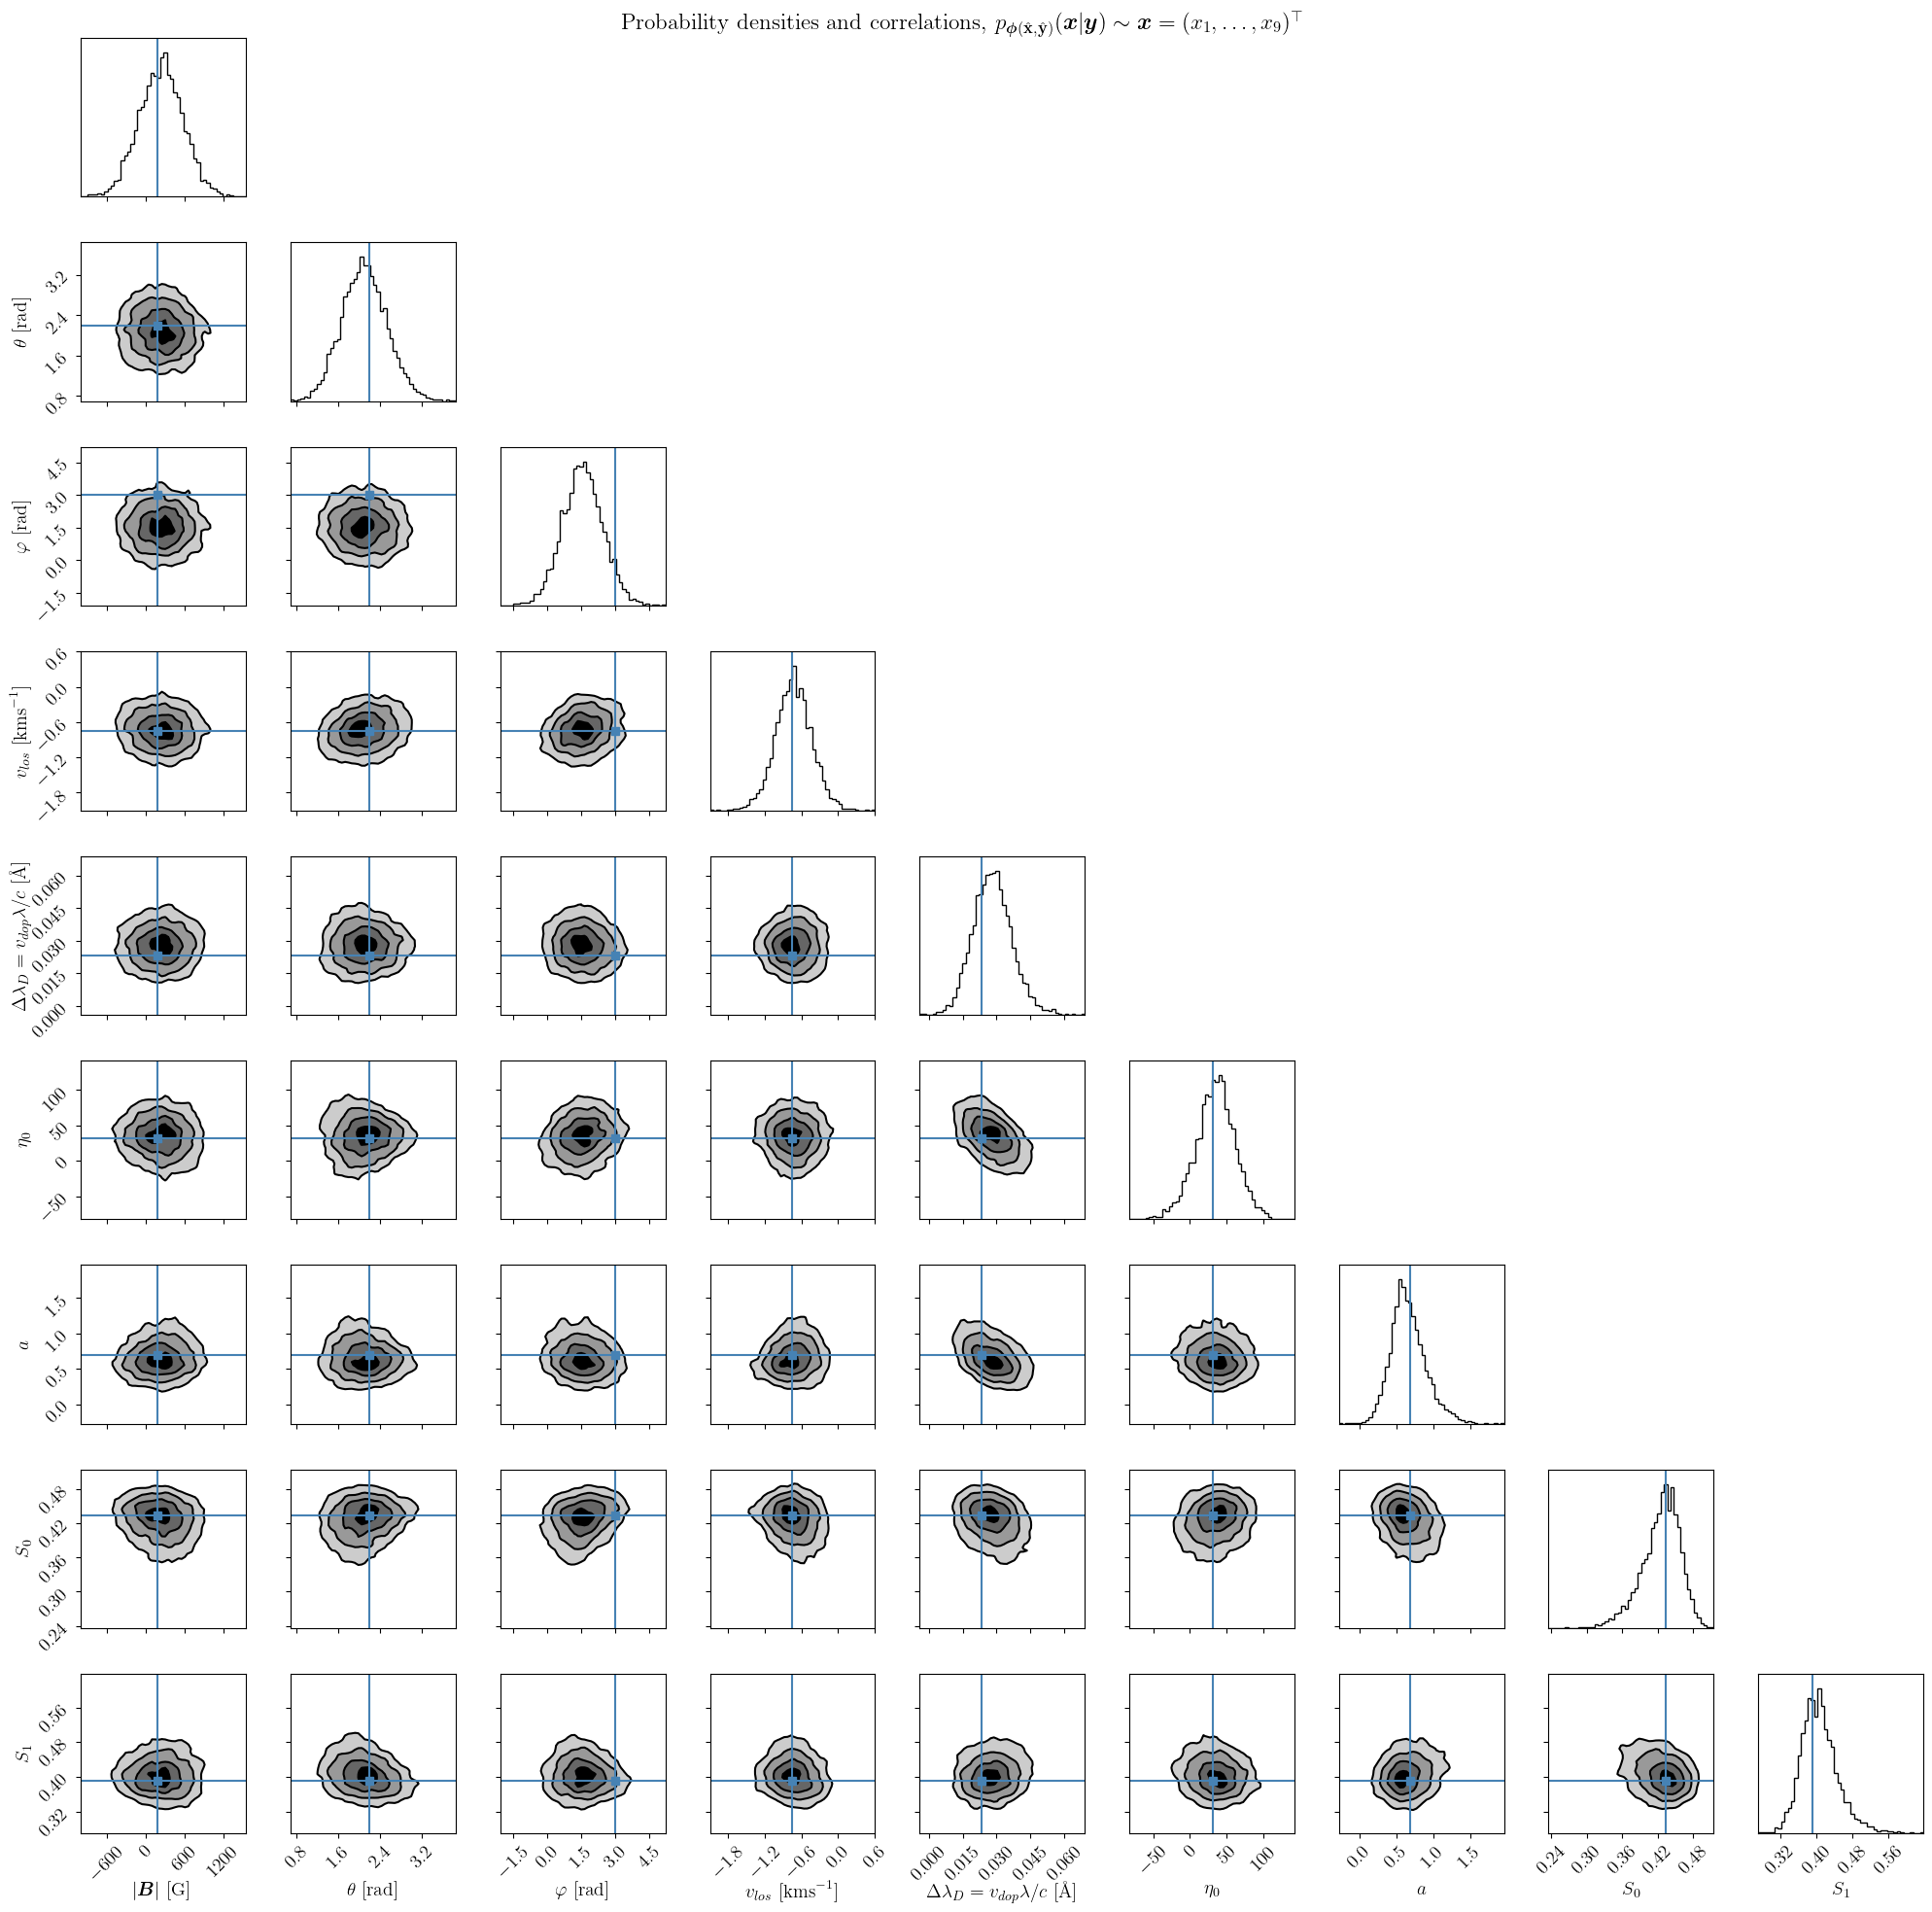

In [32]:
# Produce corner plot
figure = corner.corner(rec_x, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations, $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-1-corner.pdf')